<a href="https://colab.research.google.com/github/vikrammitra/prometheus/blob/main/TestPEFTLoraLudwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

In [2]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [ ]:
import pandas as pd
from datetime import datetime, timedelta

sentiment_data = pd.read_csv("/content/drive/MyDrive/sample_data/all-data.csv", header=None , encoding='ISO-8859-1')
sentiment_data.columns =['sentiment' ,'sentence']
sentiment_data['sentence'] = sentiment_data['sentence'].replace(r'\W', ' ', regex=True)
sentiment_data['sentence'] = sentiment_data['sentence'].str.lower()
sentiment_data = sentiment_data.sample(50)

sentiment_data.drop_duplicates(subset=['sentence'],keep='first',inplace=True)

def making_label(st):
    if(st=='positive'):
        return 0
    elif(st=='neutral'):
        return 2
    else:
        return 1

sentiment_data['label'] = sentiment_data['sentiment'].apply(making_label)


In [16]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = sentiment_data
total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)
df.rename({'sentiment': 'output', 'sentence': 'input'}, axis=1, inplace=True)
df['instruction'] = 'What is the sentiment of this Headline?'
df = df.drop(['label'],axis = 1)
df.head(10)

,output,input,split,instruction
1858,neutral,of bavelloni s and nst s joint ventures ba...,0,What is the sentiment of this Headline?
2961,neutral,in the sinter plant limestone and coke breez...,0,What is the sentiment of this Headline?
535,positive,with the launch of new 3g handsets nokia aim...,0,What is the sentiment of this Headline?
1848,neutral,honkarakenne oyj a world leading manufacture...,1,What is the sentiment of this Headline?
37,positive,aspo plc stock exchange release february 11 ...,0,What is the sentiment of this Headline?
705,positive,upm s deliveries increased during the thir...,0,What is the sentiment of this Headline?
4647,negative,26 october 2010 finnish environmental manage...,0,What is the sentiment of this Headline?
3271,neutral,the insolvency act regulates the amount of deb...,0,What is the sentiment of this Headline?
874,positive,pioneer library system was one of 127 librarie...,0,What is the sentiment of this Headline?
234,positive,neste oil corp has signed long term procureme...,0,What is the sentiment of this Headline?


Average number of tokens in the instruction column: 13
Average number of tokens in the input column: 52
Average number of tokens in the output column: 2



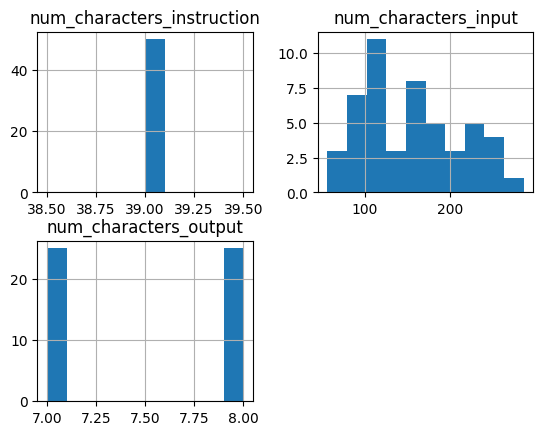

In [17]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
df['num_characters_input'] = df['input'].apply(lambda x: len(x))
df['num_characters_output'] = df['output'].apply(lambda x: len(x))

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

In [18]:
qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: huggyllama/llama-7b

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 100

adapter:
  type: lora

quantization:
  bits: 4

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=True`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.features.text_feature:Max length of feature 'None': 144 (without start and stop symbols)
INFO:ludwig.features.text_feature:Setting max length using dataset: 146 (including start and stop symbols)
INFO:ludwig.features.text_feature:max sequence length is 146 for feature 'None'
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.featur

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.pri

trainable params: 4,194,304 || all params: 6,742,609,920 || trainable%: 0.06220594176090199


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 175 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 175 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:  19%|█▉        | 34/175 [00:21<01:15,  1.88it/s, loss=1.03]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  20%|██        | 35/175 [00:22<01:33,  1.50it/s, loss=1.11]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 35, epoch: 1


Evaluation test : 100%|██████████| 5/5 [00:05<00:00,  1.15s/it]

INFO:ludwig.trainers.trainer:Evaluation took 7.7663s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0000 │       1.0000 │     1.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │    17.6995 │      17.0247 │    17.2053 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 31999.8184 │   32000.8066 │ 31999.6758 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31964.2852 │   31966.7266 │ 31950.5410 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.000


Training:  39%|███▉      | 68/175 [00:47<00:58,  1.84it/s, loss=1.08]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  40%|████      | 70/175 [00:49<01:03,  1.65it/s, loss=1.08]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 70, epoch: 2


Evaluation test : 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.6579s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0000 │       1.0000 │     1.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │    17.2314 │      16.9901 │    17.1773 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 32000.8867 │   32000.8281 │ 31999.6621 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31988.5293 │   31966.7871 │ 31950.3906 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.000


Training:  58%|█████▊    | 102/175 [01:13<00:40,  1.78it/s, loss=1.06]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  60%|██████    | 105/175 [01:15<00:42,  1.64it/s, loss=1.05]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 105, epoch: 3


Evaluation test : 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

INFO:ludwig.trainers.trainer:Evaluation took 7.9082s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0000 │       1.0000 │     1.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │    16.7211 │      16.9638 │    17.1493 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 31999.5469 │   32000.8066 │ 31999.6445 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31962.8848 │   31966.9688 │ 31950.2363 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.000


Training:  78%|███████▊  | 136/175 [01:40<00:21,  1.79it/s, loss=1.04]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training:  80%|████████  | 140/175 [01:43<00:22,  1.56it/s, loss=1.06]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 140, epoch: 4


Evaluation test : 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]

INFO:ludwig.trainers.trainer:Evaluation took 7.3575s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0000 │       1.0000 │     1.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │    17.0337 │      16.9197 │    17.1118 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 31999.9434 │   32000.8184 │ 31999.6309 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31957.4590 │   31966.6934 │ 31949.8105 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.000


Training:  97%|█████████▋| 170/175 [02:08<00:03,  1.56it/s, loss=1.02]

INFO:ludwig.data.batcher.random_access:Last batch in epoch only has 1 sample and will be dropped.


Training: 100%|██████████| 175/175 [02:11<00:00,  1.58it/s, loss=1.06]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 175, epoch: 5


Evaluation test : 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

INFO:ludwig.trainers.trainer:Evaluation took 6.9489s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0000 │       0.0000 │     0.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     1.0000 │       1.0000 │     1.0000 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │    16.9125 │      16.8785 │    17.0813 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 31997.1348 │   32000.8184 │ 31999.5684 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 32000.2793 │   31966.6035 │ 31950.1445 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0.000


Training: 100%|██████████| 175/175 [02:19<00:00,  1.26it/s, loss=1.06]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤═══════════════════╕
│ Validation feature           │ output            │
├──────────────────────────────┼───────────────────┤
│ Validation metric            │ loss              │
├──────────────────────────────┼───────────────────┤
│ Best model step              │ 175               │
├──────────────────────────────┼───────────────────┤
│ Best model epoch             │ 6                 │
├──────────────────────────────┼───────────────────┤
│ Best model's validation loss │ 16.87846565246582 │
├──────────────────────────────┼───────────────────┤
│ Best model's test loss       │ 17.08126449584961 │
╘══════════════════════════════╧═══════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to: /content/re

In [24]:
test_sp_data  = pd.read_csv("/content/drive/MyDrive/sample_data/SP500_sample_news.csv",encoding='ISO-8859-1')
test_sp_data_pred = test_sp_data[['Title']]
test_sp_data_pred.rename({'Title': 'input'}, axis=1, inplace=True)
test_sp_data_pred['instruction'] = 'What is the sentiment of this Headline?'
test_sp_data_pred['input'] = test_sp_data_pred['input'].replace(r'\W', ' ', regex=True)
test_sp_data_pred['input'] = test_sp_data_pred['input'].str.lower()
test_sp_data_pred.head(10)

<ipython-input-24-89e3121dd8e2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sp_data_pred.rename({'Title': 'input'}, axis=1, inplace=True)
<ipython-input-24-89e3121dd8e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sp_data_pred['instruction'] = 'What is the sentiment of this Headline?'
<ipython-input-24-89e3121dd8e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,input,instruction
0,the 10 richest people in the world are worth ...,What is the sentiment of this Headline?
1,market on close imbalance 1 6b to sell side,What is the sentiment of this Headline?
2,market on close imbalance 238m to sell side,What is the sentiment of this Headline?
3,major indexes are lower after july ppi data sh...,What is the sentiment of this Headline?
4,white house s kirby says there is opportunity ...,What is the sentiment of this Headline?
5,white house s kirby says united states is open...,What is the sentiment of this Headline?
6,what s going on with nvidia stock friday,What is the sentiment of this Headline?
7,us stocks falter on ppi data nasdaq hits 1 mo...,What is the sentiment of this Headline?
8,u s baker hughes gas rig count 5 from last w...,What is the sentiment of this Headline?
9,market clubhouse morning memo august 11th 2...,What is the sentiment of this Headline?


In [25]:
predictions = model.predict(test_sp_data_pred)[0]
for input_with_prediction in zip(test_sp_data_pred['instruction'], test_sp_data_pred['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")

INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of huggyllama/llama-7b tokenizer


Prediction:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "max_length": 32,
  "max_new_tokens": 100,
  "temperature": 0.1,
  "transformers_version": "4.32.1"
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: below is an instruction that describes a task, paired with an input that provides further context. write a response that appropriately completes the request.
### instruction: what is the sentiment of this headline?
### input: the 10 richest people in the world are worth  1 4 trillion  the same as amazon   â   here s who has gained the most in 2023
### response:
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
INFO:ludwig.models.llm:Decoded generated output for the first example in batch

KeyboardInterrupt: ignored